# Segmentación de clientes (Costumer Segmentation)

Base de datos de:

https://www.kaggle.com/blastchar/telco-customer-churn/

Datos y Notebook basada de: https://github.com/MaartenGr/CustomerSegmentation

notas en: https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

 y autor: Maarten Grootendorst


In [1]:
#librerías necesarias:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
#import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

## Base de Datos Pública de Telecom
Telcom Customer Churn:  Each row represents a customer, each column contains customer’s attributes described on the column Metadata. The raw data contains 7043 rows (customers) and 21 columns (features). The “Churn” column is our target.


In [2]:
df_cruda = pd.read_csv("data.csv")
df_cruda.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### Pre-procesado de la base

In [3]:
# remove empty values
df=df_cruda.copy()
df = df.loc[df.TotalCharges!=" ", :]
df.TotalCharges = df.TotalCharges.astype(float)
    
# Label data correctly
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'PaperlessBilling', 'Churn']
for i in replace_cols : 
    df.loc[:, i]  = df.loc[:, i].replace({'No internet service' : 'No', 'No phone service':'No'})
    df.loc[:, i]  = df.loc[:, i].map({'No':0, 'Yes':1})
df.gender = df.gender.map({"Female":0, "Male":1})
    
# One-hot encoding of variables
others_categorical = ['Contract', 'PaymentMethod', 'InternetService']
for i in others_categorical:
    df = df.join(pd.get_dummies(df[i], prefix=i))
df.drop(others_categorical, axis=1, inplace=True)

# Calculate number of services
services = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'InternetService_DSL', 'InternetService_Fiber optic',
        'InternetService_No']
df['nr_services'] = df.apply(lambda row: sum([row[x] for x in services[:-1]]), 1)

df=df.drop('customerID', axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,nr_services
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,2
1,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,0,1,1,0,0,4
2,1,0,0,0,2,1,0,1,1,0,...,0,0,0,0,0,1,1,0,0,4
3,1,0,0,0,45,0,0,1,0,1,...,1,0,1,0,0,0,1,0,0,4
4,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,2


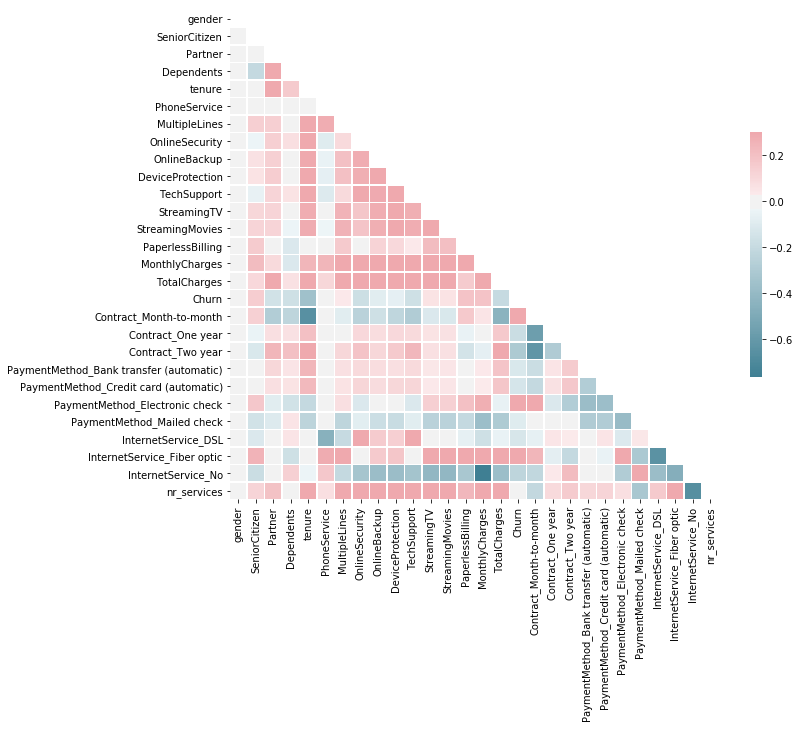

In [4]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

plot_corr(df)

Text(0,0.5,'tenure')

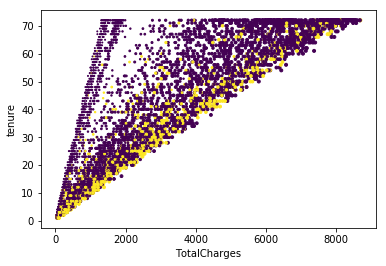

In [5]:
plt.scatter(df.TotalCharges, df.tenure,c=df.Churn,s=df.nr_services)
plt.xlabel('TotalCharges')
plt.ylabel('tenure')

**El target de la base de datos es “Churn”, la quitamos**

In [6]:
df=df.drop('Churn', axis=1)

# Métodos de Clustering:

## K-medias

* ES necesario definirle la cantidad de grupos/clusters, es un hiperparámetro del algoritmo. 

In [7]:
kmedias3=KMeans(n_clusters=3).fit(df)
print(kmedias3)
print('Suma de los cuadrados de las distancias al clusters / Inertia: ', kmedias3.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
Suma de los cuadrados de las distancias al clusters / Inertia:  3701544886.044164


* Una forma de seleccionar la cantidad más adecuada es probar varias cantidades y usar el criterio del codo "elbow method", utilizando una medida de ajuste (puede ser Inertia). 


Text(0.5,1,'Inertia of k-Means versus number of clusters')

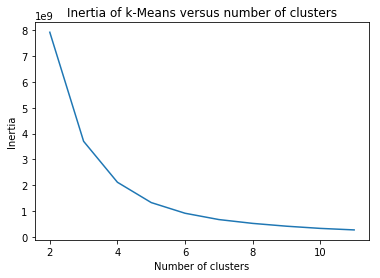

In [8]:
# n_clusters de 2 a 9
scores = [KMeans(n_clusters=i+2).fit(df).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [9]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5,1,'Inertia of Cosine k-Means versus number of clusters')

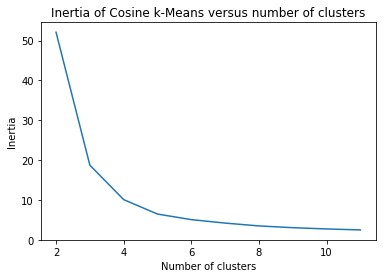

In [10]:
#Distancia del coseno (normalizar los vectores)
normalized_vectors = preprocessing.normalize(df)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")

In [11]:
normalized_kmeans = KMeans(n_clusters=4)
normalized_kmeans.fit(normalized_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### DBSCAN: Density Based Spatial Clustering of Aplications with Noise
* NO es necesario definirle la cantidad de grupos/clusters 
* Hipeparámetros: eps (o radio de búsqueda) y min_samples (Rule of thumb: si D es la cantidad de variables, min_samples  ≥ D + 1) 

In [12]:
min_samples = df.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(df)

## Evaluación

In [13]:
from collections import Counter
print('cantidad de datos por cluster con kmedias: ',Counter(kmeans.labels_))
print('cantidad de datos por cluster en dist. coseno: ',Counter(normalized_kmeans.labels_))
print('cantidad de datos por cluster de DBSCAN: ',Counter(dbscan.labels_))

cantidad de datos por cluster con kmedias:  Counter({1: 3177, 3: 1695, 2: 1185, 0: 975})
cantidad de datos por cluster en dist. coseno:  Counter({0: 5131, 2: 858, 1: 616, 3: 427})
cantidad de datos por cluster de DBSCAN:  Counter({-1: 6533, 2: 179, 0: 160, 1: 123, 3: 37})


In [14]:
print('kmeans: {}'.format(silhouette_score(df, kmeans.labels_, metric='euclidean')))
print('Cosine kmeans: {}'.format(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine')))
print('DBSCAN: {}'.format(silhouette_score(df, dbscan.labels_, metric='cosine')))

kmeans: 0.6018648189794878
Cosine kmeans: 0.8633823077551214
DBSCAN: 0.8302013261718773


In [15]:
# Setting all variables between 0 and 1 in order to better visualize the results
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns
df_scaled['kmedias'] = kmeans.labels_
df_scaled['kmed_cos'] = normalized_kmeans.labels_
df_scaled['dbscan'] = dbscan.labels_
df_scaled.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,nr_services,kmedias,kmed_cos,dbscan
0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.125,1,1,-1
1,1.0,0.0,0.0,0.0,0.464789,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.375,3,0,-1
2,1.0,0.0,0.0,0.0,0.014085,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.375,1,3,-1
3,1.0,0.0,0.0,0.0,0.619718,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.375,3,0,-1
4,0.0,0.0,0.0,0.0,0.014085,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.125,1,3,-1


In [ ]:
#df['dbscan'] = dbscan.labels_
#tidy = df_scaled.melt(id_vars='dbscan')
#fig, ax = plt.subplots(figsize=(15, 5))
#sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='Set3')
#plt.legend([''])
#plt.savefig("dbscan_mess.jpg", dpi=300)

![](dbscan_mess.jpg)

**Muchas variables para analizar, nos quedamos con las "más importantes"**

In [16]:
df_mean = df_scaled.loc[df_scaled.dbscan!=-1, :].groupby('dbscan').mean().reset_index()

In [17]:
df_mean

,dbscan,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,nr_services,kmedias,kmed_cos
0,0,0.593750,0.018750,0.168750,0.218750,0.0,1.000000,0.000000,0.000000,0.000000,...,0.081250,0.068750,0.112500,0.737500,0.000000,0.0,1.000000,0.000000,1,1
1,1,0.609756,0.105691,0.097561,0.154472,0.0,0.967480,0.073171,0.130081,0.089431,...,0.081301,0.073171,0.398374,0.447154,1.000000,0.0,0.000000,0.183943,1,1
2,2,0.480447,0.251397,0.195531,0.145251,0.0,1.000000,0.184358,0.022346,0.083799,...,0.039106,0.027933,0.731844,0.201117,0.000000,1.0,0.000000,0.194134,1,1
3,3,0.432432,0.216216,0.108108,0.189189,0.0,0.162162,0.162162,0.000000,0.000000,...,0.054054,0.000000,0.432432,0.513514,0.837838,0.0,0.162162,0.020270,1,1


In [19]:
# Calculate variables with largest differences (by standard deviation)
# The higher the standard deviation in a variable based on average values for each cluster
# The more likely that the variable is important when creating the cluster
df_mean = df_scaled.loc[df_scaled.dbscan!=-1, :].groupby('dbscan').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['dbscan']

# Plot data
#tidy = df_scaled[selected_columns].melt(id_vars='dbscan')
#fig, ax = plt.subplots(figsize=(15, 5))
#sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='Set3')
#plt.legend(loc='upper right')
#plt.savefig("dbscan_results.jpg", dpi=300)

![](dbscan_results.jpg)

In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,nr_services
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,2
1,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,0,1,1,0,0,4
2,1,0,0,0,2,1,0,1,1,0,...,0,0,0,0,0,1,1,0,0,4
3,1,0,0,0,45,0,0,1,0,1,...,1,0,1,0,0,0,1,0,0,4
4,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,2


In [24]:
from sklearn.ensemble import RandomForestClassifier
y = dbscan.labels_
X = df#.iloc[:,:]
clf = RandomForestClassifier(n_estimators=100).fit(X, y)
selected_columns = list(pd.DataFrame(np.array([clf.feature_importances_, df.columns]).T, columns=['Importance', 'Feature'])
           .sort_values("Importance", ascending=False)
           .head(7)
           .Feature
           .values)

In [ ]:
# Plot data
#tidy = df_scaled[selected_columns+['dbscan']].melt(id_vars='dbscan')
#fig, ax = plt.subplots(figsize=(15, 5))
#sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='Set3')
#plt.legend(loc='upper right')
#plt.savefig('randomforest.jpg', dpi=300)

![](randomforest.jpg)

# Visualización
** Visualización con PCA: Análisis de Componentes Principales**

In [25]:
def prepare_pca(n_components, data):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
        
    return df_matrix

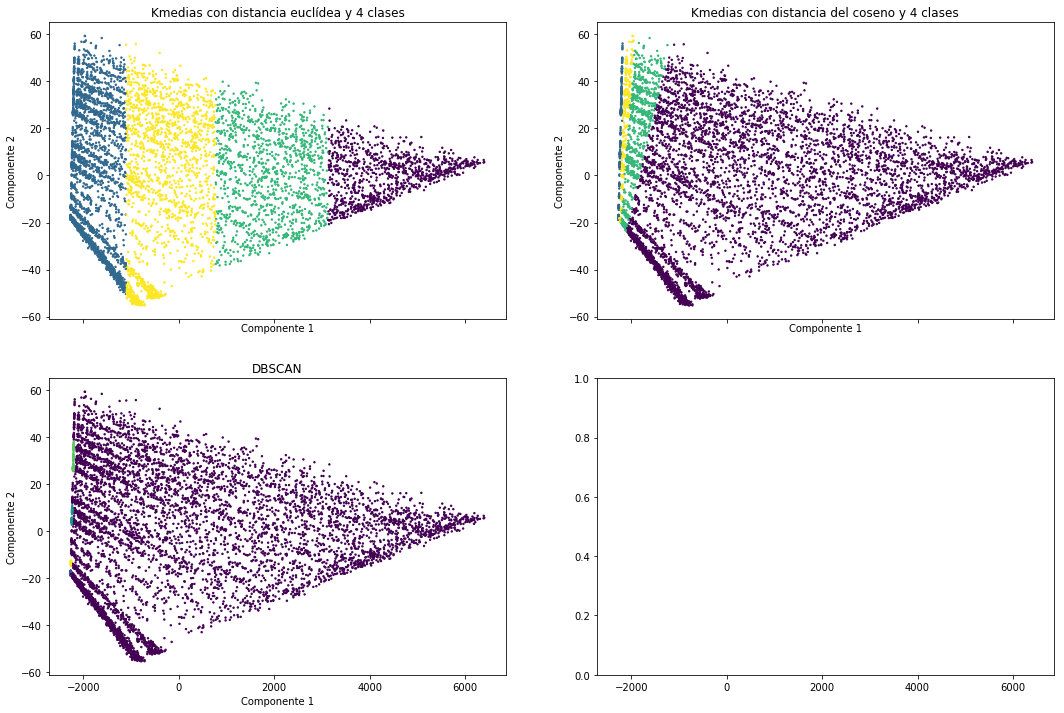

In [26]:
pca_df = prepare_pca(3, df)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_figheight(12)
fig.set_figwidth(18)
axs[0,0].scatter(x=pca_df.x, y=pca_df.y,c=kmeans.labels_, label=kmeans.labels_, s=2)
axs[0,0].set_title('Kmedias con distancia euclídea y 4 clases')
axs[0,0].set_xlabel('Componente 1')
axs[0,0].set_ylabel('Componente 2')

axs[0,1].scatter(x=pca_df.x, y=pca_df.y,c=normalized_kmeans.labels_, label=normalized_kmeans.labels_, s=2)
axs[0,1].set_title('Kmedias con distancia del coseno y 4 clases')
axs[0,1].set_xlabel('Componente 1')
axs[0,1].set_ylabel('Componente 2')

axs[1,0].scatter(x=pca_df.x, y=pca_df.y,c=dbscan.labels_, label=dbscan.labels_, s=2)
axs[1,0].set_title('DBSCAN')
axs[1,0].set_xlabel('Componente 1')
axs[1,0].set_ylabel('Componente 2')


plt.show()

In [27]:
from collections import Counter
print('cantidad de datos por cluster con kmedias: ',Counter(kmeans.labels_))
print('cantidad de datos por cluster en dist. coseno: ',Counter(normalized_kmeans.labels_))
print('cantidad de datos por cluster de DBSCAN: ',Counter(dbscan.labels_))

cantidad de datos por cluster con kmedias:  Counter({1: 3177, 3: 1695, 2: 1185, 0: 975})
cantidad de datos por cluster en dist. coseno:  Counter({0: 5131, 2: 858, 1: 616, 3: 427})
cantidad de datos por cluster de DBSCAN:  Counter({-1: 6533, 2: 179, 0: 160, 1: 123, 3: 37})


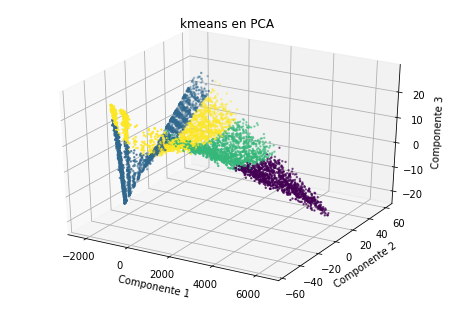

In [28]:
from mpl_toolkits.mplot3d import Axes3D

target=kmeans.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_df.x, pca_df.y, pca_df.z,c=target,label=target, s=2)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.title('kmeans en PCA')
plt.show()

# Visualización
** Visualización con tSNE: t-distributed Sochastic Neigbhor Embedding**

In [29]:
#funciones para visualización 
def prepare_tsne(n_components, data):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
        
    return df_matrix

In [ ]:
tsne_3d_df = prepare_tsne(3, df)
##....

![](clusters.gif)

## Mean Shift
* NO es necesario definirle la cantidad de grupos/clusters 
* NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
* Hipeparámetros: minsize (tamaño mínimo de los clusters), radio (de cobertura y cálculo de media)
